In [33]:
# Header from RIT notebook
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
##Setting up Google sdk environment
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/jhlu/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-nigam-starr' #som-nero-phi-rit
%load_ext google.cloud.bigquery
##Setting up BQ API
from google.cloud import bigquery
client=bigquery.Client()
import numpy as np
import pandas as pd
import datetime
import collections
from IPython.display import display, HTML
import json

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/home/jhlu/.local/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [17]:
plt.rcParams['figure.figsize'] = [12.0, 8.0]
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18

pd.options.display.max_columns = 100

In [3]:
metadata = collections.OrderedDict()

In [4]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [5]:
check_null_query = """
WITH

resultsSARSCoV2Tests AS
(
  SELECT meas.person_id, visit_occurrence_id, measurement_DATE, measurement_DATETIME, value_source_value, value_source_value IN ('Detected','Pos','Positive') AS detectedSARSCoV2, visit_concept_id, care_site_name
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.measurement` as meas
  LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` USING (visit_occurrence_id)
  LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.care_site` USING (care_site_id)
  WHERE measurement_concept_id = 706170 -- SARS-CoV2 NAA Test Result
  AND meas.value_source_value is NOT NULL -- Only capture usable results and not extra descriptors
)
  
select count(*) nRecords, count(distinct person_id) as nPerson, count(distinct visit_occurrence_id) as nVisits, countif(value_source_value is not null) as nonNullValues
from resultsSARSCoV2Tests 
"""


tmp_null_df = client.query(check_null_query).to_dataframe(progress_bar_type='tqdm')
print("Sanity check on null SARS-CoV2 NAA records:")

display(HTML(tmp_null_df.to_html()))

print("% non-null values among pulled records", 
      100.* tmp_null_df["nonNullValues"][0]/tmp_null_df["nRecords"][0])



Downloading: 100%|██████████| 1/1 [00:00<00:00,  6.53rows/s]

Sanity check on null SARS-CoV2 NAA records:


,nRecords,nPerson,nVisits,nonNullValues
0,68018,46407,65023,68018


% non-null values among pulled records 100.0


In [6]:
# -- Collate patients receiving any recent acute respiratory illness (ARI) diagnosis
# -- Look for any patient with an ARI, based on diagnosis code list suggested by CDC,
#--  that was recorded recently since testing was available (first date was 03/02/2020)
#-- Since Starr-OMOP jitters by +/- 31 days and we wish to cover all COVID tests, we use
#-- a start date of 01/31/2020


query = """
WITH

-- all visits involving an acute respiratory illness ICD-10 diagnosis with date since 01/31/2020
recentARI AS
( 
SELECT
    condOccur.person_id, visit_occurrence_id, condition_start_DATE, condition_start_DATETIME, 
    condition_source_value, condition_source_concept_id,
    visit_concept_id, care_site_name
  FROM
    `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.condition_occurrence` AS condOccur 
  LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` USING (visit_occurrence_id)
  LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.care_site` USING (care_site_id)
  WHERE
    condition_start_DATE >= '2020-01-31' AND
    ( condition_source_value LIKE 'J00.%' OR
      condition_source_value LIKE 'J01.%' OR
      condition_source_value LIKE 'J02.%' OR
      condition_source_value LIKE 'J03.%' OR
      condition_source_value LIKE 'J04.%' OR
      condition_source_value LIKE 'J05.%' OR
      condition_source_value LIKE 'J06.%' OR
      condition_source_value LIKE 'J09.%' OR
      condition_source_value LIKE 'J10.%' OR
      condition_source_value LIKE 'J11.%' OR
      condition_source_value LIKE 'J12.%' OR
      condition_source_value LIKE 'J13.%' OR
      condition_source_value LIKE 'J14.%' OR
      condition_source_value LIKE 'J15.%' OR
      condition_source_value LIKE 'J16.%' OR
      condition_source_value LIKE 'J17.%' OR
      condition_source_value LIKE 'J18.%' OR
      condition_source_value LIKE 'J20.%' OR
      condition_source_value LIKE 'J21.%' OR
      condition_source_value LIKE 'J22' OR
      condition_source_value LIKE 'J80' OR
      condition_source_value LIKE 'A37.91' OR
      condition_source_value LIKE 'A37.01' OR
      condition_source_value LIKE 'A37.11' OR
      condition_source_value LIKE 'A37.81' OR
      condition_source_value LIKE 'A48.1' OR
      condition_source_value LIKE 'B25.0' OR
      condition_source_value LIKE 'B44.0' OR
      condition_source_value LIKE 'B97.4' OR
      condition_source_value LIKE 'U07.1'
    )
),


-- patient's first ARI visit in date range
firstARIInfo AS
(
SELECT person_id, firstARIDateTime, firstARI_visit_concept_id, firstARI_care_site_name
FROM (
  SELECT 
    person_id, 
    condition_start_DATETIME AS firstARIDateTime,
    visit_concept_id AS firstARI_visit_concept_id,
    care_site_name AS firstARI_care_site_name,
    row_number() OVER (partition by person_id ORDER BY condition_start_DATETIME ASC) AS row_num
   FROM recentARI
) AS r
WHERE r.row_num=1
),


-- patient's last ARI visit in date range
lastARIInfo AS
(
SELECT person_id, lastARIDateTime, lastARI_visit_concept_id, lastARI_care_site_name
FROM (
  SELECT 
    person_id, 
    condition_start_DATETIME AS lastARIDateTime,
    visit_concept_id AS lastARI_visit_concept_id,
    care_site_name AS lastARI_care_site_name,
    row_number() OVER (partition by person_id ORDER BY condition_start_DATETIME DESC) AS row_num
   FROM recentARI
) AS r
WHERE r.row_num=1
),


-- Inner join patient's first and last ARI visits
recentARIDateTimeRange AS
(
SELECT person_id, lastARIDateTime, lastARI_visit_concept_id, lastARI_care_site_name,
firstARIDateTime, firstARI_visit_concept_id, firstARI_care_site_name
FROM firstARIInfo
INNER JOIN lastARIInfo USING (person_id)
)
,


-- all SARS-CoV2 NAA Test Results
resultsSARSCoV2Tests AS
(
  SELECT meas.person_id, visit_occurrence_id, measurement_DATE, measurement_DATETIME, value_source_value, value_source_value IN ('Detected','Pos','Positive') AS detectedSARSCoV2, visit_concept_id, care_site_name
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.measurement` as meas
  LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` USING (visit_occurrence_id)
  LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.care_site` USING (care_site_id)
  WHERE measurement_concept_id = 706170 -- SARS-CoV2 NAA Test Result
  AND meas.value_source_value is NOT NULL -- Only capture usable results and not extra descriptors
) ,

-- first SARS-CoV2 NAA Test
firstTestInfo AS
(
SELECT person_id, firstSARSCoV2TestedDateTime, firstTest_visit_concept_id, firstTest_care_site_name
FROM (
  SELECT 
    person_id, 
    measurement_DATETIME AS firstSARSCoV2TestedDateTime,
    visit_concept_id AS firstTest_visit_concept_id,
    care_site_name AS firstTest_care_site_name,
    row_number() OVER (partition by person_id ORDER BY measurement_DATETIME ASC) AS row_num
   FROM resultsSARSCoV2Tests
) AS r
WHERE r.row_num=1
),

-- last SARS-CoV2 NAA Test
lastTestInfo AS
(
SELECT person_id, lastSARSCoV2TestedDateTime, lastTest_visit_concept_id, lastTest_care_site_name
FROM (
  SELECT 
    person_id, 
    measurement_DATETIME AS lastSARSCoV2TestedDateTime,
    visit_concept_id AS lastTest_visit_concept_id,
    care_site_name AS lastTest_care_site_name,
    row_number() OVER (partition by person_id ORDER BY measurement_DATETIME DESC) AS row_num
   FROM resultsSARSCoV2Tests
) AS r
WHERE r.row_num=1
),

-- Accounting for multiple possible tests per patient, Inner join patient's first and last SARS coV2 tests
resultsSARSCoV2DateTimeRange AS(
  SELECT 
    person_id, 
    firstSARSCoV2TestedDateTime, firstTest_visit_concept_id, firstTest_care_site_name,
    lastSARSCoV2TestedDateTime, lastTest_visit_concept_id, lastTest_care_site_name,
    firstSARSCoV2DetectedDateTime, lastSARSCoV2DetectedDateTime
  FROM firstTestInfo
  INNER JOIN lastTestInfo USING (person_id)
  
  -- Left outer join, because not everyone who had a test will have a positive test result to join to
  
  LEFT JOIN 
  (
    SELECT person_id, MIN(measurement_DATETIME) AS firstSARSCoV2DetectedDateTime, MAX(measurement_DATETIME) AS lastSARSCoV2DetectedDateTime
    FROM resultsSARSCoV2Tests
    WHERE resultsSARSCoV2Tests.detectedSARSCoV2
    GROUP BY person_id 
  ) AS firstLastDetectedSARSCoV2Tests
  USING (person_id)
  ),

-- at this point:
--  recentARIDateTimeRange has one row per patient (41,341 rows as of 2020-04-20 cdm_release_DATE)
--  resultsSARSCoV2DateTimeRange has one row per patient (14,838)

-- now let's combine: 
-- Each with first and last dates of occurrences of ARI (after initial "recent" cutoff date) or SARS-CoV2 test results (including timing of positive/detected result, null if no positive/detected results)

recentARIandSARSCoV2DateTimeRange AS
( -- Full outer join in both directions because some people with ARI diagnosis don't get SARS-CoV2 testing and vice versa
  SELECT *,
      DATETIME_DIFF( firstSARSCoV2TestedDateTime, firstARIDateTime, DAY ) daysFirstARItoFirstSARSCoV2Tested,
      DATETIME_DIFF( firstSARSCoV2TestedDateTime, lastARIDateTime, DAY ) daysLastARItoFirstSARSCoV2Tested,
      DATETIME_DIFF( lastSARSCoV2TestedDateTime, firstARIDateTime, DAY ) daysFirstARItoLastSARSCoV2Tested,
      DATETIME_DIFF( lastSARSCoV2TestedDateTime, lastARIDateTime, DAY ) daysLastARItoLastSARSCoV2Tested,

      DATETIME_DIFF( firstSARSCoV2DetectedDateTime, firstARIDateTime, DAY ) daysFirstARItoFirstSARSCoV2Detected,
      DATETIME_DIFF( firstSARSCoV2DetectedDateTime, lastARIDateTime, DAY ) daysLastARItoFirstSARSCoV2Detected,
      DATETIME_DIFF( lastSARSCoV2DetectedDateTime, firstARIDateTime, DAY ) daysFirstARItoLastSARSCoV2Detected,
      DATETIME_DIFF( lastSARSCoV2DetectedDateTime, lastARIDateTime, DAY ) daysLastARItoLastSARSCoV2Detected,
  FROM 
    recentARIDateTimeRange FULL JOIN 
    resultsSARSCoV2DateTimeRange USING (person_id)
  -- 4,091 inner join results (recent ARI diagnosis code AND SARS-CoV2 test results exist, but not necessarily in the correct datetime order)
  -- 52,088 full outer join results (recent ARI diagnosi code OR SARS-CoV2 test results)
)

SELECT 
    recentARIandSARSCoV2DateTimeRange.*,
    year_of_birth, DATE_DIFF('2020-02-01', DATE(birth_DATETIME), YEAR) ageAsOfFeb2020,
    person.gender_concept_id , genderConc.concept_name AS genderConcept,
    person.race_source_value, person.race_concept_id, raceConc.concept_name as raceConcept,
    person.ethnicity_source_value, person.ethnicity_concept_id, ethnicityConc.concept_name as ethnicityConcept
  FROM 
    recentARIandSARSCoV2DateTimeRange 
    JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.person` AS person USING (person_id) 
    LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.concept` AS genderConc ON (person.gender_concept_id = genderConc.concept_id)
    LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.concept` AS raceConc ON (person.race_concept_id = raceConc.concept_id)
    LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.concept` AS ethnicityConc ON (person.ethnicity_concept_id = ethnicityConc.concept_id)
"""

In [7]:
query_job = client.query(query)
df = query_job.to_dataframe(progress_bar_type='tqdm')

Downloading: 100%|██████████| 66897/66897 [00:17<00:00, 3814.83rows/s]


In [8]:
print("Columns", df.columns)

Columns Index(['person_id', 'lastARIDateTime', 'lastARI_visit_concept_id',
       'lastARI_care_site_name', 'firstARIDateTime',
       'firstARI_visit_concept_id', 'firstARI_care_site_name',
       'firstSARSCoV2TestedDateTime', 'firstTest_visit_concept_id',
       'firstTest_care_site_name', 'lastSARSCoV2TestedDateTime',
       'lastTest_visit_concept_id', 'lastTest_care_site_name',
       'firstSARSCoV2DetectedDateTime', 'lastSARSCoV2DetectedDateTime',
       'daysFirstARItoFirstSARSCoV2Tested', 'daysLastARItoFirstSARSCoV2Tested',
       'daysFirstARItoLastSARSCoV2Tested', 'daysLastARItoLastSARSCoV2Tested',
       'daysFirstARItoFirstSARSCoV2Detected',
       'daysLastARItoFirstSARSCoV2Detected',
       'daysFirstARItoLastSARSCoV2Detected',
       'daysLastARItoLastSARSCoV2Detected', 'year_of_birth', 'ageAsOfFeb2020',
       'gender_concept_id', 'genderConcept', 'race_source_value',
       'race_concept_id', 'raceConcept', 'ethnicity_source_value',
       'ethnicity_concept_id', 'eth

In [9]:
ARI = df['lastARIDateTime'].notnull().rename('ARI')
tested = df['lastSARSCoV2TestedDateTime'].notnull().rename('tested')
detected = df['lastSARSCoV2DetectedDateTime'].notnull().rename('detected')

in_time_range = lambda col : df[col].between(0, 60)
in_time_ranges = lambda col1, col2 : in_time_range(col1) | in_time_range(col2)

# was either the first or last ARI 60 days before the first COVID-test?
# was either the first or last ARI 60 days before the first COVID-positive test?
ARI_tested_60 = in_time_ranges('daysFirstARItoFirstSARSCoV2Tested', 'daysLastARItoFirstSARSCoV2Tested').rename('ARI_tested_60')
ARI_detected_60 = in_time_ranges('daysFirstARItoFirstSARSCoV2Detected', 'daysLastARItoFirstSARSCoV2Detected').rename('ARI_detected_60')

# age categorical
bins = [0, 5, 18, 50, 65, 75, 85, 100]
labels = ["[{:02d}, {:02d})".format(i, j) for i, j in zip(bins[:-1], bins[1:])]
age_cat = pd.cut(df['ageAsOfFeb2020'], bins, labels=labels).rename('age')

df['care_site'] = df['firstTest_care_site_name'].fillna(df['lastARI_care_site_name'])
df['visit_concept'] = df['firstTest_visit_concept_id'].fillna(df['lastARI_visit_concept_id'])

In [10]:
df_all = pd.concat([df, ARI, tested, detected, ARI_tested_60, ARI_detected_60, age_cat], axis=1)
df_all.head()

,person_id,lastARIDateTime,lastARI_visit_concept_id,lastARI_care_site_name,firstARIDateTime,firstARI_visit_concept_id,firstARI_care_site_name,firstSARSCoV2TestedDateTime,firstTest_visit_concept_id,firstTest_care_site_name,...,ethnicity_concept_id,ethnicityConcept,care_site,visit_concept,ARI,tested,detected,ARI_tested_60,ARI_detected_60,age
0,43717922,2020-02-23 06:30:00,9201.0,None,2020-02-23 06:30:00,9201.0,None,NaT,NaN,None,...,38003563,Hispanic or Latino,None,9201.0,True,False,False,False,False,"[65, 75)"
1,30001785,2020-02-15 00:00:00,0.0,STANFORD EXPRESS CARE SAN JOSE,2020-02-15 00:00:00,0.0,STANFORD EXPRESS CARE SAN JOSE,NaT,NaN,None,...,38003563,Hispanic or Latino,STANFORD EXPRESS CARE SAN JOSE,0.0,True,False,False,False,False,"[18, 50)"
2,43988872,NaT,NaN,None,NaT,NaN,None,2020-04-13 10:56:00,9203.0,None,...,38003563,Hispanic or Latino,None,9203.0,False,True,False,False,False,"[65, 75)"
3,43755215,2020-03-20 14:26:00,5083.0,STANFORD PRIMARY CARE SANTA CLARA,2020-03-20 00:00:00,5083.0,STANFORD PRIMARY CARE SANTA CLARA,NaT,NaN,None,...,38003563,Hispanic or Latino,STANFORD PRIMARY CARE SANTA CLARA,5083.0,True,False,False,False,False,"[18, 50)"
4,32089890,NaT,NaN,None,NaT,NaN,None,2020-04-16 17:42:00,9203.0,None,...,38003563,Hispanic or Latino,None,9203.0,False,True,False,False,False,"[18, 50)"


In [11]:
print('Totals')
for elt in ['ARI', 'tested', 'detected', 'ARI_tested_60', 'ARI_detected_60']:
    df_all[elt] = df_all[elt].astype('int32')
    metadata["total_" + str(elt)] = np.sum(df_all[elt])
    print(elt, np.sum(df_all[elt]))

Totals
ARI 29241
tested 46407
detected 1732
ARI_tested_60 7012
ARI_detected_60 561


In [12]:
print('confirm person_id is unique')
df_all['person_id'].is_unique

confirm person_id is unique


True

In [13]:
print("Num nulls per column")
df_all.isnull().sum()

Num nulls per column


person_id                                  0
lastARIDateTime                        37656
lastARI_visit_concept_id               38496
lastARI_care_site_name                 43287
firstARIDateTime                       37656
firstARI_visit_concept_id              38579
firstARI_care_site_name                43597
firstSARSCoV2TestedDateTime            20490
firstTest_visit_concept_id             20769
firstTest_care_site_name               26804
lastSARSCoV2TestedDateTime             20490
lastTest_visit_concept_id              20752
lastTest_care_site_name                27230
firstSARSCoV2DetectedDateTime          65165
lastSARSCoV2DetectedDateTime           65165
daysFirstARItoFirstSARSCoV2Tested      58146
daysLastARItoFirstSARSCoV2Tested       58146
daysFirstARItoLastSARSCoV2Tested       58146
daysLastARItoLastSARSCoV2Tested        58146
daysFirstARItoFirstSARSCoV2Detected    66110
daysLastARItoFirstSARSCoV2Detected     66110
daysFirstARItoLastSARSCoV2Detected     66110
daysLastAR

Oldest nSars-COV2-test
2020-01-15 15:35:00
None
Newest nSars-COV2-test
2020-06-27 14:37:00
None
---
Oldest nSars-COV2-detection
2020-02-11 15:10:00
Newest nSars-COV2-detection
2020-06-25 10:20:00
---


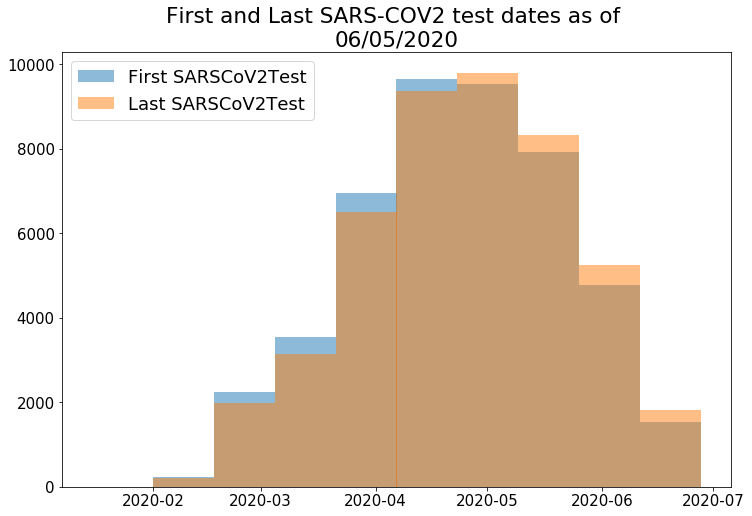

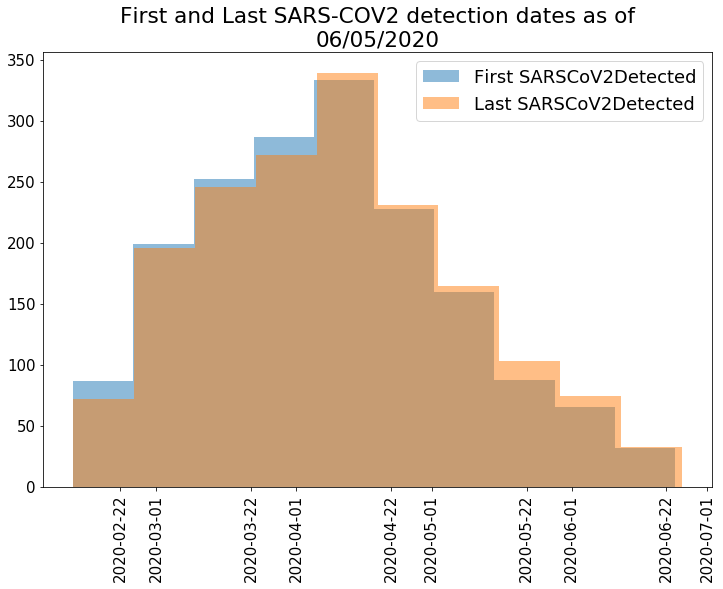

In [14]:
print("Oldest nSars-COV2-test")
print(print(min(df_all[df_all["firstSARSCoV2TestedDateTime"].notnull()]["firstSARSCoV2TestedDateTime"])))
print("Newest nSars-COV2-test")
print(print(max(df_all[df_all["lastSARSCoV2TestedDateTime"].notnull()]["lastSARSCoV2TestedDateTime"])))
print("---")
print("Oldest nSars-COV2-detection")
print(min(df_all[df_all["firstSARSCoV2DetectedDateTime"].notnull()]["firstSARSCoV2DetectedDateTime"]))
print("Newest nSars-COV2-detection")
print(max(df_all[df_all["lastSARSCoV2DetectedDateTime"].notnull()]["lastSARSCoV2DetectedDateTime"]))
print("---")

plt.figure()
plt.hist(df_all[df_all["firstSARSCoV2TestedDateTime"].notnull()]["firstSARSCoV2TestedDateTime"],
        alpha=0.5, label="First SARSCoV2Test")
plt.hist(df_all[df_all["lastSARSCoV2TestedDateTime"].notnull()]["lastSARSCoV2TestedDateTime"],
        alpha=0.5, label="Last SARSCoV2Test")
plt.title("First and Last SARS-COV2 test dates as of \n" + datetime.datetime.today().strftime("%m/%d/%Y"))
plt.legend()
plt.show()
plt.close()

plt.figure()
plt.hist(df_all[df_all["firstSARSCoV2DetectedDateTime"].notnull()]["firstSARSCoV2DetectedDateTime"],
        alpha=0.5, label="First SARSCoV2Detected")
plt.hist(df_all[df_all["lastSARSCoV2DetectedDateTime"].notnull()]["lastSARSCoV2DetectedDateTime"],
        alpha=0.5, label="Last SARSCoV2Detected")
plt.title("First and Last SARS-COV2 detection dates as of\n" + datetime.datetime.today().strftime("%m/%d/%Y"))
plt.xticks(rotation=90)
plt.legend()
plt.show()
plt.close()


In [30]:
# take a look at ARI visit dates




2020-01-15 15:35:00


In [67]:
df_all['ethnicity_source_value'].value_counts().to_csv('ethnicity_source')
df_all['race_source_value'].value_counts().to_csv('race_source')
# for ind, grp in df_all.groupby('raceConcept'):
#     print(ind)
#     print(grp['race_source_value'].unique())
for ind, grp in df_all.groupby('ethnicityConcept'):
    print(ind)
    print(grp['ethnicity_source_value'].unique())

Hispanic or Latino
['Hispanic/Latino |' 'Hispanic/Latino | Not Hispanic'
 'Hispanic/Latino | Hispanic' 'Hispanic/Latino | Unknown'
 'Unknown | Hispanic' '| Hispanic' 'Hispanic/Latino | Declines to State'
 'Patient Refused | Hispanic']
No matching concept
['Unknown |' 'Patient Refused |' '| Declines to State' '|' '| Unknown'
 'Unknown | Declines to State' 'Patient Refused | Declines to State'
 'Unknown | Unknown' 'Patient Refused | Unknown']
Not Hispanic or Latino
['Non-Hispanic/Non-Latino |' 'Non-Hispanic/Non-Latino | Not Hispanic'
 'Non-Hispanic/Non-Latino | Hispanic' 'Non-Hispanic/Non-Latino | Unknown'
 '| Not Hispanic' 'Unknown | Not Hispanic'
 'Patient Refused | Not Hispanic'
 'Non-Hispanic/Non-Latino | Declines to State']


In [22]:
out_cols = ["ARI", "tested", "detected", "ARI_tested_60", "ARI_detected_60"]

In [23]:
df_all.groupby('ethnicityConcept')[out_cols].sum()

,ARI,tested,detected,ARI_tested_60,ARI_detected_60
ethnicityConcept,,,,,
Hispanic or Latino,4343,5636,355,1124,199
No matching concept,5387,13894,860,990,129
Not Hispanic or Latino,19511,26877,517,4898,233


In [24]:
df_all.groupby('age')[out_cols].sum()

,ARI,tested,detected,ARI_tested_60,ARI_detected_60
age,,,,,
"[00, 05)",4208,1137,17,208,9
"[05, 18)",5666,1827,58,318,25
"[18, 50)",10440,24147,881,3505,327
"[50, 65)",4805,9592,413,1673,125
"[65, 75)",2459,5802,191,832,46
"[75, 85)",1258,3107,124,382,19
"[85, 100)",316,731,45,79,7


In [25]:
df_all.groupby('raceConcept')[out_cols].sum()

,ARI,tested,detected,ARI_tested_60,ARI_detected_60
raceConcept,,,,,
American Indian or Alaska Native,71,122,2,17,0
Asian,5077,6427,123,1070,62
Black or African American,1067,1380,29,231,16
Native Hawaiian or Other Pacific Islander,315,472,12,77,6
No matching concept,9881,19845,1190,2256,309
White,12830,18161,376,3361,168


In [26]:
visit_token = 'visit_concept'
from IPython.display import display, HTML
def df_disp(df):
    display(HTML(df.to_html()))

def format_by_visit(ind_nm):
    tbl = pd.pivot_table(df_all, values=['ARI', 'tested', 'detected', 'ARI_tested_60', 'ARI_detected_60'], index=[ind_nm],
                            columns=[visit_token], aggfunc=np.sum)
    p_tbl = tbl.T.rename(columns=str).reset_index()
    p_tbl = p_tbl.rename({'level_0' : 'type'}, axis=1).sort_values([visit_token, 'type'])

    cols = p_tbl.columns.tolist()
    cols = [cols[1], cols[0]] + cols[2:]
    p_tbl = p_tbl[cols]
    df_disp(p_tbl)
    return p_tbl

def format_by_ind(ind_nm, write_folder="run_dumps"):
    tbl = pd.pivot_table(df_all, values=['ARI', 'tested', 'detected', 'ARI_tested_60', 'ARI_detected_60'], index=[ind_nm],
                            aggfunc=np.sum)
    p_tbl = tbl.T
    df_disp(p_tbl)
    return p_tbl

In [28]:
care_site_tok = 'care_site'
print("Saving care site counts")
save_care_site_csv = lambda s, tok : s.value_counts().to_csv('care_site_counts_' + tok + '_visit.csv')
save_care_site_csv(df_all[care_site_tok], 'all')
save_care_site_csv(df_all[care_site_tok][df_all['ARI'] == 1], 'ARI')
save_care_site_csv(df_all[care_site_tok][df_all['tested'] == 1], 'tested')
save_care_site_csv(df_all[care_site_tok][df_all['detected'] == 1], 'detected')

Saving care site counts


In [29]:
for elt in ['age', 'ethnicityConcept', 'raceConcept', 'genderConcept']:
    format_by_visit(elt)
    format_by_ind(elt)

age,visit_concept,type,"[00, 05)","[05, 18)","[18, 50)","[50, 65)","[65, 75)","[75, 85)","[85, 100)"
0,0.0,ARI,3309,4631,6093,2664,1350,635,154
8,0.0,ARI_detected_60,8,16,183,60,17,4,1
16,0.0,ARI_tested_60,131,215,2167,723,329,141,25
24,0.0,detected,14,42,683,307,144,88,35
32,0.0,tested,820,1288,19518,5923,3409,1794,435
1,262.0,ARI,84,47,106,143,129,139,62
9,262.0,ARI_detected_60,0,0,29,11,10,9,5
17,262.0,ARI_tested_60,11,5,64,73,78,79,34
25,262.0,detected,0,0,29,11,11,9,6
33,262.0,tested,20,29,474,451,352,323,128


age,"[00, 05)","[05, 18)","[18, 50)","[50, 65)","[65, 75)","[75, 85)","[85, 100)"
ARI,4208,5666,10440,4805,2459,1258,316
ARI_detected_60,9,25,327,125,46,19,7
ARI_tested_60,208,318,3505,1673,832,382,79
detected,17,58,881,413,191,124,45
tested,1137,1827,24147,9592,5802,3107,731


ethnicityConcept,visit_concept,type,Hispanic or Latino,No matching concept,Not Hispanic or Latino
0,0.0,ARI,2402,4710,11777
8,0.0,ARI_detected_60,77,111,103
16,0.0,ARI_tested_60,571,766,2403
24,0.0,detected,204,827,284
32,0.0,tested,3432,13078,16721
1,262.0,ARI,179,3,540
9,262.0,ARI_detected_60,30,0,35
17,262.0,ARI_tested_60,74,2,270
25,262.0,detected,30,0,37
33,262.0,tested,368,20,1391


ethnicityConcept,Hispanic or Latino,No matching concept,Not Hispanic or Latino
ARI,4343,5387,19511
ARI_detected_60,199,129,233
ARI_tested_60,1124,990,4898
detected,355,860,517
tested,5636,13894,26877


raceConcept,visit_concept,type,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,No matching concept,White
0,0.0,ARI,42,3177,611,169,7026,7864
8,0.0,ARI_detected_60,0,29,9,4,172,77
16,0.0,ARI_tested_60,8,566,104,40,1329,1693
24,0.0,detected,2,62,18,5,1005,223
32,0.0,tested,72,4334,782,302,16368,11373
1,262.0,ARI,2,115,41,16,207,341
9,262.0,ARI_detected_60,0,12,2,0,33,18
17,262.0,ARI_tested_60,1,53,20,6,94,172
25,262.0,detected,0,13,2,0,33,19
33,262.0,tested,5,299,115,37,451,872


raceConcept,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,No matching concept,White
ARI,71,5077,1067,315,9881,12830
ARI_detected_60,0,62,16,6,309,168
ARI_tested_60,17,1070,231,77,2256,3361
detected,2,123,29,12,1190,376
tested,122,6427,1380,472,19845,18161


genderConcept,visit_concept,type,FEMALE,MALE,No matching concept
0,0.0,ARI,10636.0,8247.0,6.0
8,0.0,ARI_detected_60,165.0,126.0,0.0
16,0.0,ARI_tested_60,2463.0,1273.0,4.0
24,0.0,detected,649.0,666.0,0.0
32,0.0,tested,22401.0,10802.0,28.0
1,262.0,ARI,307.0,415.0,0.0
9,262.0,ARI_detected_60,29.0,36.0,0.0
17,262.0,ARI_tested_60,149.0,197.0,0.0
25,262.0,detected,29.0,38.0,0.0
33,262.0,tested,826.0,952.0,1.0


genderConcept,FEMALE,MALE,No matching concept
ARI,15917,13315,9
ARI_detected_60,269,292,0
ARI_tested_60,4037,2970,5
detected,811,921,0
tested,28709,17666,32


In [30]:
for elt in ['age', 'ethnicity_source_value', 'race_source_value', 'genderConcept']:
    format_by_visit(elt)
    format_by_ind(elt)
    

age,visit_concept,type,"[00, 05)","[05, 18)","[18, 50)","[50, 65)","[65, 75)","[75, 85)","[85, 100)"
0,0.0,ARI,3309,4631,6093,2664,1350,635,154
8,0.0,ARI_detected_60,8,16,183,60,17,4,1
16,0.0,ARI_tested_60,131,215,2167,723,329,141,25
24,0.0,detected,14,42,683,307,144,88,35
32,0.0,tested,820,1288,19518,5923,3409,1794,435
1,262.0,ARI,84,47,106,143,129,139,62
9,262.0,ARI_detected_60,0,0,29,11,10,9,5
17,262.0,ARI_tested_60,11,5,64,73,78,79,34
25,262.0,detected,0,0,29,11,11,9,6
33,262.0,tested,20,29,474,451,352,323,128


age,"[00, 05)","[05, 18)","[18, 50)","[50, 65)","[65, 75)","[75, 85)","[85, 100)"
ARI,4208,5666,10440,4805,2459,1258,316
ARI_detected_60,9,25,327,125,46,19,7
ARI_tested_60,208,318,3505,1673,832,382,79
detected,17,58,881,413,191,124,45
tested,1137,1827,24147,9592,5802,3107,731


ethnicity_source_value,visit_concept,type,Hispanic/Latino |,Hispanic/Latino | Declines to State,Hispanic/Latino | Hispanic,Hispanic/Latino | Not Hispanic,Hispanic/Latino | Unknown,Non-Hispanic/Non-Latino |,Non-Hispanic/Non-Latino | Declines to State,Non-Hispanic/Non-Latino | Hispanic,Non-Hispanic/Non-Latino | Not Hispanic,Non-Hispanic/Non-Latino | Unknown,Patient Refused |,Patient Refused | Declines to State,Patient Refused | Hispanic,Patient Refused | Not Hispanic,Patient Refused | Unknown,Unknown |,Unknown | Declines to State,Unknown | Hispanic,Unknown | Not Hispanic,Unknown | Unknown,|,| Declines to State,| Hispanic,| Not Hispanic,| Unknown
0,0.0,ARI,1145.0,12.0,461.0,155.0,102.0,6335.0,90.0,96.0,2051.0,701.0,528.0,13.0,10.0,68.0,26.0,571.0,24.0,28.0,193.0,114.0,1138.0,388.0,489.0,2243.0,1908.0
8,0.0,ARI_detected_60,32.0,0.0,41.0,0.0,0.0,75.0,0.0,2.0,16.0,4.0,1.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,3.0,1.0,97.0,1.0,4.0,3.0,2.0
16,0.0,ARI_tested_60,325.0,1.0,165.0,37.0,12.0,1711.0,11.0,25.0,469.0,99.0,106.0,1.0,0.0,10.0,3.0,177.0,0.0,3.0,25.0,18.0,431.0,5.0,28.0,53.0,25.0
24,0.0,detected,131.0,0.0,65.0,0.0,2.0,220.0,1.0,5.0,40.0,8.0,7.0,0.0,0.0,0.0,1.0,58.0,0.0,0.0,5.0,3.0,755.0,1.0,6.0,5.0,2.0
32,0.0,tested,2006.0,9.0,878.0,239.0,61.0,11875.0,57.0,171.0,3251.0,500.0,446.0,6.0,11.0,75.0,12.0,1562.0,8.0,51.0,229.0,85.0,10754.0,35.0,177.0,563.0,170.0
1,262.0,ARI,90.0,0.0,56.0,7.0,3.0,432.0,NaN,6.0,80.0,11.0,1.0,NaN,NaN,0.0,NaN,2.0,NaN,0.0,2.0,0.0,NaN,NaN,23.0,9.0,0.0
9,262.0,ARI_detected_60,25.0,0.0,4.0,0.0,0.0,34.0,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0
17,262.0,ARI_tested_60,54.0,0.0,7.0,3.0,2.0,240.0,NaN,1.0,23.0,3.0,0.0,NaN,NaN,0.0,NaN,2.0,NaN,0.0,1.0,0.0,NaN,NaN,8.0,2.0,0.0
25,262.0,detected,25.0,0.0,4.0,0.0,0.0,36.0,NaN,0.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0
33,262.0,tested,270.0,1.0,55.0,5.0,3.0,1220.0,NaN,5.0,114.0,14.0,7.0,NaN,NaN,2.0,NaN,10.0,NaN,3.0,9.0,2.0,NaN,NaN,31.0,27.0,1.0


ethnicity_source_value,Hispanic/Latino |,Hispanic/Latino | Declines to State,Hispanic/Latino | Hispanic,Hispanic/Latino | Not Hispanic,Hispanic/Latino | Unknown,Non-Hispanic/Non-Latino |,Non-Hispanic/Non-Latino | Declines to State,Non-Hispanic/Non-Latino | Hispanic,Non-Hispanic/Non-Latino | Not Hispanic,Non-Hispanic/Non-Latino | Unknown,Patient Refused |,Patient Refused | Declines to State,Patient Refused | Hispanic,Patient Refused | Not Hispanic,Patient Refused | Unknown,Unknown |,Unknown | Declines to State,Unknown | Hispanic,Unknown | Not Hispanic,Unknown | Unknown,|,| Declines to State,| Hispanic,| Not Hispanic,| Unknown
ARI,2224,17,1083,252,178,12248,124,187,3316,988,670,13,15,83,31,963,25,30,232,136,1184,402,544,2333,1963
ARI_detected_60,129,1,61,2,1,192,1,4,24,5,2,0,0,0,1,20,0,0,4,1,102,1,5,3,2
ARI_tested_60,737,3,266,56,21,3798,13,44,786,151,150,1,1,13,4,332,0,3,31,23,450,5,37,62,25
detected,249,1,92,2,4,426,2,7,59,12,8,0,0,0,1,84,0,0,6,3,761,1,7,5,2
tested,3587,15,1302,308,90,20395,72,245,4409,721,642,8,13,96,14,2088,11,65,279,100,10813,38,256,660,180


race_source_value,visit_concept,type,American Indian or Alaska Native |,American Indian or Alaska Native | American Indian or Alaska Native,American Indian or Alaska Native | Asian,American Indian or Alaska Native | Black or African American,American Indian or Alaska Native | Other,American Indian or Alaska Native | Unknown,American Indian or Alaska Native | White or Caucasian,Asian |,Asian | American Indian or Alaska Native,Asian | Asian,Asian | Black or African American,Asian | Declines to State,Asian | Native Hawaiian or Other Pacific Islander,Asian | Other,Asian | Unknown,Asian | White or Caucasian,"Asian, Hispanic | Unknown","Asian, non-Hispanic |","Asian, non-Hispanic | Asian","Asian, non-Hispanic | White or Caucasian",Black or African American |,Black or African American | American Indian or Alaska Native,Black or African American | Asian,Black or African American | Black or African American,Black or African American | Declines to State,Black or African American | Other,Black or African American | Unknown,Black or African American | White or Caucasian,"Black, Hispanic |","Black, non-Hispanic |","Black, non-Hispanic | Black or African American","Native American, Hispanic |","Native American, non-Hispanic |","Native American, non-Hispanic | American Indian or Alaska Native",Native Hawaiian or Other Pacific Islander |,Native Hawaiian or Other Pacific Islander | Asian,Native Hawaiian or Other Pacific Islander | Native Hawaiian or Other Pacific Islander,Native Hawaiian or Other Pacific Islander | Other,Native Hawaiian or Other Pacific Islander | Unknown,Native Hawaiian or Other Pacific Islander | White or Caucasian,Other |,Other | American Indian or Alaska Native,Other | Asian,Other | Black or African American,Other | Declines to State,Other | Native Hawaiian or Other Pacific Islander,Other | Other,Other | Unknown,Other | White or Caucasian,"Other, Hispanic |","Other, Hispanic | Asian","Other, Hispanic | Black or African American","Other, Hispanic | Declines to State","Other, Hispanic | Native Hawaiian or Other Pacific Islander","Other, Hispanic | Other","Other, Hispanic | Unknown","Other, Hispanic | White or Caucasian","Other, non-Hispanic |","Other, non-Hispanic | Asian","Other, non-Hispanic | Other","Other, non-Hispanic | White or Caucasian","Pacific Islander, non-Hispanic |","Pacific Islander, non-Hispanic | Native Hawaiian or Other Pacific Islander",Patient Refused |,Patient Refused | American Indian or Alaska Native,Patient Refused | Asian,Patient Refused | Black or African American,Patient Refused | Declines to State,Patient Refused | Native Hawaiian or Other Pacific Islander,Patient Refused | Other,Patient Refused | Unknown,Patient Refused | White or Caucasian,Race and Ethnicity Unknown |,Race and Ethnicity Unknown | American Indian or Alaska Native,Race and Ethnicity Unknown | Asian,Race and Ethnicity Unknown | Black or African American,Race and Ethnicity Unknown | Declines to State,Race and Ethnicity Unknown | Other,Race and Ethnicity Unknown | Unknown,Race and Ethnicity Unknown | White or Caucasian,Unknown |,Unknown | American Indian or Alaska Native,Unknown | Asian,Unknown | Black or African American,Unknown | Declines to State,Unknown | Native Hawaiian or Other Pacific Islander,Unknown | Other,Unknown | Unknown,Unknown | White or Caucasian,White |,White | American Indian or Alaska Native,White | Asian,White | Black or African American,White | Declines to State,White | Native Hawaiian or Other Pacific Islander,White | Other,White | Unknown,White | White or Caucasian,"White, Hispanic |","White, Hispanic | Other","White, Hispanic | White or Caucasian","White, non-Hispanic |","White, non-Hispanic | Declines to State","White, non-Hispanic | Other","White, non-Hispanic | Unknown","White, non-Hispanic | White or Caucasian",|,| American Indian or Alaska Native,| Asian,| Black or African American,| Declines to State,| Native Hawaiian or Other Pacific Islander,| Other,| Unknown,| White or Caucasian
0,0.0,ARI,21.0,1.0,2.0,

race_source_value,American Indian or Alaska Native |,American Indian or Alaska Native | American Indian or Alaska Native,American Indian or Alaska Native | Asian,American Indian or Alaska Native | Black or African American,American Indian or Alaska Native | Other,American Indian or Alaska Native | Unknown,American Indian or Alaska Native | White or Caucasian,Asian |,Asian | American Indian or Alaska Native,Asian | Asian,Asian | Black or African American,Asian | Declines to State,Asian | Native Hawaiian or Other Pacific Islander,Asian | Other,Asian | Unknown,Asian | White or Caucasian,"Asian, Hispanic |","Asian, Hispanic | Unknown","Asian, non-Hispanic |","Asian, non-Hispanic | Asian","Asian, non-Hispanic | White or Caucasian",Black or African American |,Black or African American | American Indian or Alaska Native,Black or African American | Asian,Black or African American | Black or African American,Black or African American | Declines to State,Black or African American | Other,Black or African American | Unknown,Black or African American | White or Caucasian,"Black, Hispanic |","Black, non-Hispanic |","Black, non-Hispanic | Black or African American","Native American, Hispanic |","Native American, non-Hispanic |","Native American, non-Hispanic | American Indian or Alaska Native",Native Hawaiian or Other Pacific Islander |,Native Hawaiian or Other Pacific Islander | Asian,Native Hawaiian or Other Pacific Islander | Native Hawaiian or Other Pacific Islander,Native Hawaiian or Other Pacific Islander | Other,Native Hawaiian or Other Pacific Islander | Unknown,Native Hawaiian or Other Pacific Islander | White or Caucasian,Other |,Other | American Indian or Alaska Native,Other | Asian,Other | Black or African American,Other | Declines to State,Other | Native Hawaiian or Other Pacific Islander,Other | Other,Other | Unknown,Other | White or Caucasian,"Other, Hispanic |","Other, Hispanic | Asian","Other, Hispanic | Black or African American","Other, Hispanic | Declines to State","Other, Hispanic | Native Hawaiian or Other Pacific Islander","Other, Hispanic | Other","Other, Hispanic | Unknown","Other, Hispanic | White or Caucasian","Other, non-Hispanic |","Other, non-Hispanic | Asian","Other, non-Hispanic | Other","Other, non-Hispanic | White or Caucasian","Pacific Islander, non-Hispanic |","Pacific Islander, non-Hispanic | Native Hawaiian or Other Pacific Islander",Patient Refused |,Patient Refused | American Indian or Alaska Native,Patient Refused | Asian,Patient Refused | Black or African American,Patient Refused | Declines to State,Patient Refused | Native Hawaiian or Other Pacific Islander,Patient Refused | Other,Patient Refused | Unknown,Patient Refused | White or Caucasian,Race and Ethnicity Unknown |,Race and Ethnicity Unknown | American Indian or Alaska Native,Race and Ethnicity Unknown | Asian,Race and Ethnicity Unknown | Black or African American,Race and Ethnicity Unknown | Declines to State,Race and Ethnicity Unknown | Other,Race and Ethnicity Unknown | Unknown,Race and Ethnicity Unknown | White or Caucasian,Unknown |,Unknown | American Indian or Alaska Native,Unknown | Asian,Unknown | Black or African American,Unknown | Declines to State,Unknown | Native Hawaiian or Other Pacific Islander,Unknown | Other,Unknown | Unknown,Unknown | White or Caucasian,White |,White | American Indian or Alaska Native,White | Asian,White | Black or African American,White | Declines to State,White | Native Hawaiian or Other Pacific Islander,White | Other,White | Unknown,White | White or Caucasian,"White, Hispanic |","White, Hispanic | Other","White, Hispanic | White or Caucasian","White, non-Hispanic |","White, non-Hispanic | Declines to State","White, non-Hispanic | Other","White, non-Hispanic | Unknown","White, non-Hispanic | White or Caucasian",|,| American Indian or Alaska Native,| Asian,| Black or African American,| Declines to State,| Native Hawaiian or Other Pacific Islander,| Other,| Unknown,| White or Caucasian
ARI,43,1,2,0,2,1,4,286

genderConcept,visit_concept,type,FEMALE,MALE,No matching concept
0,0.0,ARI,10636.0,8247.0,6.0
8,0.0,ARI_detected_60,165.0,126.0,0.0
16,0.0,ARI_tested_60,2463.0,1273.0,4.0
24,0.0,detected,649.0,666.0,0.0
32,0.0,tested,22401.0,10802.0,28.0
1,262.0,ARI,307.0,415.0,0.0
9,262.0,ARI_detected_60,29.0,36.0,0.0
17,262.0,ARI_tested_60,149.0,197.0,0.0
25,262.0,detected,29.0,38.0,0.0
33,262.0,tested,826.0,952.0,1.0


genderConcept,FEMALE,MALE,No matching concept
ARI,15917,13315,9
ARI_detected_60,269,292,0
ARI_tested_60,4037,2970,5
detected,811,921,0
tested,28709,17666,32


In [35]:
# change this to true if you reall ywant
export_report = True
export_files = []

if export_report:
    # export this notebook
    export_files.append("new_tbl_adj.ipynb")
    
    
    run_date = datetime.datetime.today().strftime("%y-%m-%d")
    print("Run date:", run_date)
    
    metadata["Run date"] = run_date
    metadata["Database"] = "Starr-OMOP"
    meta_out_file = "METADATA.CSV"
    
    pd.DataFrame(metadata, columns=metadata.keys()).to_csv(meta_out_file)
    print("Written to")
    
    
    
    out_folder = os.path.join("stanford_starr-omop_covid_mmwr", run_date)
    os.makedirs(out_folder, exist_ok=True)
    

    
    
    outfile = os.path.join(out_folder, "df_all_" + run_date + ".csv")
    df_all.to_csv(f, index=False)
    
    print("Writing to ", out_folder)
    print(outfile, "written")
    
    for elt in ['age', 'ethnicityConcept', 'raceConcept', 'genderConcept']:
        
        outfile = os.path.join(out_folder, elt +"_by_visit_" + run_date + ".csv")
        elt_visit = format_by_visit(elt)
        
        elt_visit.to_csv(outfile, index=True)
        print(outfile, "Written")
        
        
        outfile = os.path.join(out_folder, elt + "_by_ind_" + run_date + ".csv")
        elt_ind = format_by_ind(elt)
        
        elt_ind.to_csv(outfile, index=True)
        print(outfile, "Written")
        
        export_files.append(outfile)
        
print("Files to export", export_files)
        
        
    
    

Run date: 20-06-05


ValueError: If using all scalar values, you must pass an index

In [78]:
print("Are you sure you want to export?")
for export_file in export_files:
    print(export_file)

Are you sure you want to export?
stanford_starr-omop_covid_mmwr/20-05-20/age_by_ind_20-05-20.csv
stanford_starr-omop_covid_mmwr/20-05-20/ethnicity_source_value_by_ind_20-05-20.csv
stanford_starr-omop_covid_mmwr/20-05-20/race_source_value_by_ind_20-05-20.csv
stanford_starr-omop_covid_mmwr/20-05-20/genderConcept_by_ind_20-05-20.csv


In [79]:
with open("export_list.txt", 'w') as f:
    for export_file in export_files:
        f.write(export_file + "\n")
        
        
print("Are you sure you want to export?")
!head export_list.txt

Are you sure you want to export?
stanford_starr-omop_covid_mmwr/20-05-20/age_by_ind_20-05-20.csv
stanford_starr-omop_covid_mmwr/20-05-20/ethnicity_source_value_by_ind_20-05-20.csv
stanford_starr-omop_covid_mmwr/20-05-20/race_source_value_by_ind_20-05-20.csv
stanford_starr-omop_covid_mmwr/20-05-20/genderConcept_by_ind_20-05-20.csv


In [81]:
print("Now that export_list is updated, open a terminal and do:")
print('cd "/home/jhlu/CDSS/scripts/Covid19 CDC/"')
print('./git_export.sh')

Now that export_list is updated, open a terminal and do:
cd "/home/jhlu/CDSS/scripts/Covid19 CDC/"
./git_export.sh
